In [83]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from lstm_baseline import LSTMModel  
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

### Technical and Macro signals.

In [84]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',       # Federal Funds Rate
    'UNRATE',         # Unemployment Rate
    'GS10',           # 10-Year Treasury Yield
    'DTWEXBGS',       # Dollar Index
    'DCOILWTICO',     # Oil Prices
    'GOLD',           # Gold Prices
    'MOVE',           # MOVE Index
    'VIXCLS'          # Volatility Index (VIX)
]

technical_features = [
    'SMA_10',         # 10-day Simple Moving Average
    'SMA_50',         # 50-day Simple Moving Average
    'EMA_10',         # 10-day Exponential Moving Average
    'EMA_50',         # 50-day Exponential Moving Average
    'ROC_10',         # 10-day Rate of Change
    'RSI_14',         # 14-day Relative Strength Index
    'BB_upper',       # Upper Bollinger Band
    'BB_lower',       # Lower Bollinger Band
    'Volatility_20'   # 20-day Rolling Volatility
]

target = 'SP500'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


In [85]:

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [86]:
seq_length = 20

macro_scaler = MinMaxScaler()
X_macro_scaled = macro_scaler.fit_transform(X_macro)

tech_scaler = MinMaxScaler()
X_technical_scaled = tech_scaler.fit_transform(X_technical)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_macro)  

X_macro_seq, y_macro_seq = create_sequences(X_macro_scaled, y_scaled, seq_length)
X_technical_seq, y_technical_seq = create_sequences(X_technical_scaled, y_scaled, seq_length)


In [87]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_macro_seq, y_macro_seq)


In [88]:
import torch
import torch.nn as nn

class SP500Transformer(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super(SP500Transformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(seq_length, d_model))  # learnable positional encoding

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: [batch_size, seq_length, input_dim]
        Output: [batch_size, 1] (next-day SP500 prediction)
        """
        x = self.input_proj(x) + self.pos_encoding  # shape: [batch, seq_len, d_model]
        x = self.encoder(x)                          # shape: [batch, seq_len, d_model]
        x = x[:, -1, :]                              # use last time step's encoding
        out = self.output_layer(x)                   # shape: [batch, 1]
        return out


Epoch 1/100 | Train Loss: 0.6245 | Val Loss: 0.0489 | Test Loss: 0.1597
Epoch 2/100 | Train Loss: 0.3391 | Val Loss: 0.0457 | Test Loss: 0.1978
Epoch 3/100 | Train Loss: 0.2865 | Val Loss: 0.0508 | Test Loss: 0.2602
Epoch 4/100 | Train Loss: 0.1817 | Val Loss: 0.0577 | Test Loss: 0.3257
Epoch 5/100 | Train Loss: 0.1587 | Val Loss: 0.0488 | Test Loss: 0.3342
Epoch 6/100 | Train Loss: 0.1380 | Val Loss: 0.0653 | Test Loss: 0.4075
Epoch 7/100 | Train Loss: 0.0940 | Val Loss: 0.0530 | Test Loss: 0.3642
Epoch 8/100 | Train Loss: 0.0991 | Val Loss: 0.0470 | Test Loss: 0.3236
Epoch 9/100 | Train Loss: 0.0784 | Val Loss: 0.0475 | Test Loss: 0.3102
Epoch 10/100 | Train Loss: 0.0509 | Val Loss: 0.0442 | Test Loss: 0.2751
Epoch 11/100 | Train Loss: 0.0574 | Val Loss: 0.0396 | Test Loss: 0.2117
Epoch 12/100 | Train Loss: 0.0562 | Val Loss: 0.0423 | Test Loss: 0.2244
Epoch 13/100 | Train Loss: 0.0434 | Val Loss: 0.0405 | Test Loss: 0.1922
Epoch 14/100 | Train Loss: 0.0412 | Val Loss: 0.0369 | Test 

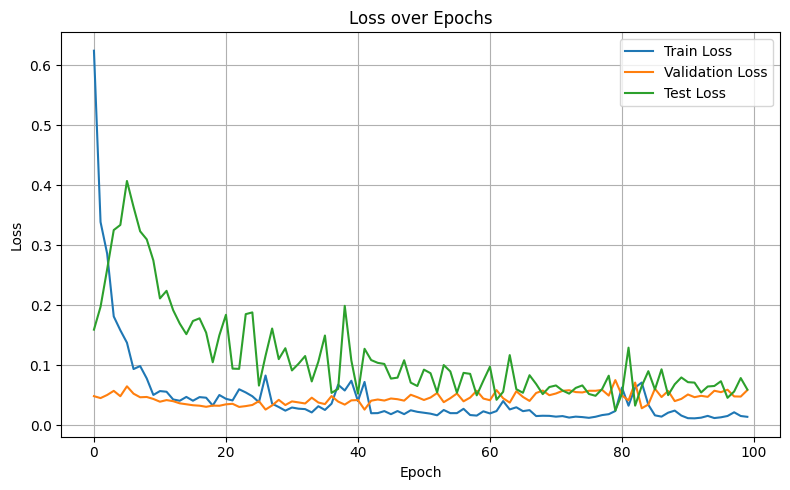

In [89]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Dataloaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model instantiation
model = SP500Transformer(
    input_dim=X_train.shape[2],
    seq_length=X_train.shape[1]
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
import matplotlib.pyplot as plt

# Create DataLoader for test set
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Training function with test loss tracking
def train_model(model, train_loader, val_loader, test_loader, epochs=100):
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")

    # Plot the losses
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, test_loader)


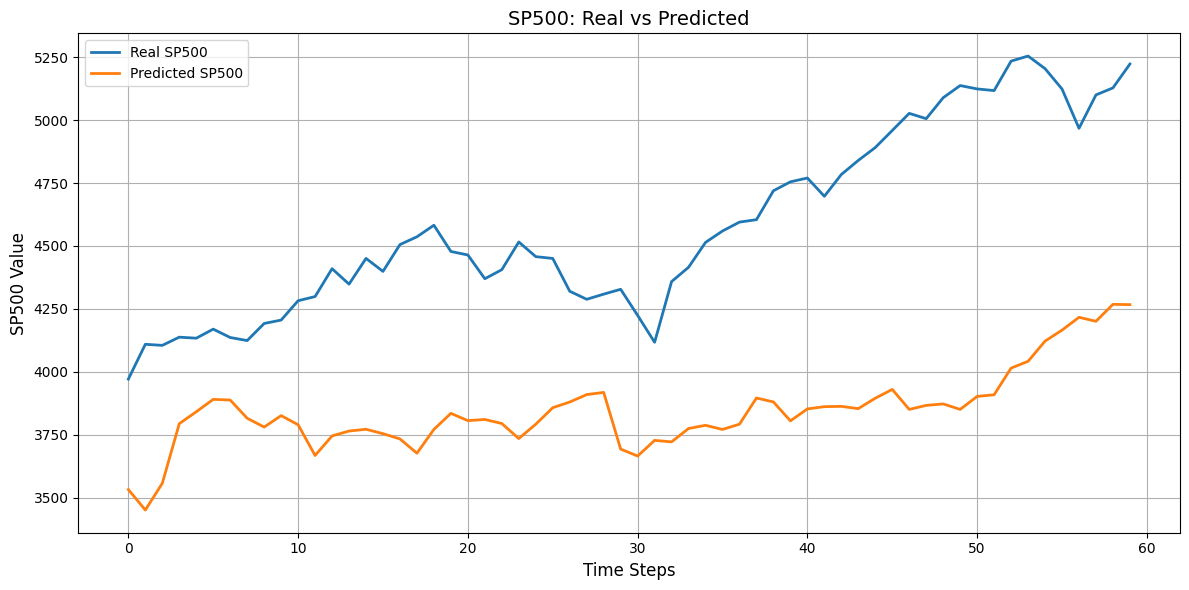

In [90]:
# Inference on test set
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
import matplotlib.pyplot as plt
import torch

# Ensure model is in evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    # Move input to device
    X_test_device = X_test.to(next(model.parameters()).device)
    
    # Predict
    preds = model(X_test_device).cpu().numpy()  # shape: [n_samples, 1]

# Convert ground truth to numpy
y_test_np = y_test.cpu().numpy()  # shape: [n_samples, 1]

# Inverse transform to original scale
sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(preds)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500', linewidth=2)
plt.plot(sp500_pred, label='Predicted SP500', linewidth=2)
plt.title('SP500: Real vs Predicted', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('SP500 Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))

# Compare direction: 1 if correct, 0 otherwise
directional_accuracy = np.mean(real_diff == pred_diff)

print(f"Directional Accuracy: {directional_accuracy:.2%}")

Directional Accuracy: 40.68%
